In [15]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, LightSource
from mpl_toolkits.basemap import Basemap, cm, pyproj
import math
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
import scipy as sc
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mintpy.utils import readfile
from scipy.interpolate import NearestNDInterpolator

Read Inversion results file

In [27]:
def get_basemap(dem_file):
    dem, atr_dem = readfile.read(dem_file)
    geo_box=[]; 
    geo_box.append(np.float(atr_dem['X_FIRST']));geo_box.append(np.float(atr_dem['Y_FIRST']));
    geo_box.append(geo_box[0]+np.int(atr_dem['WIDTH'])*np.float(atr_dem['X_STEP']));
    geo_box.append(geo_box[1]+np.int(atr_dem['FILE_LENGTH'])*np.float(atr_dem['Y_STEP']));
    map_projection='cyl'; ls = LightSource(azdeg=315, altdeg=45)
    dem_shade = ls.shade(dem, vert_exag=1.0, cmap=plt.cm.gray, vmin=-20000, vmax=np.nanmax(dem)+2500)
    return dem_shade,geo_box

def get_data_model(inversion_results_file):
    mat =sio.loadmat(inversion_results_file,struct_as_record=False,squeeze_me=True)
    Data=[];Model=[];Residual=[];Data_box=[];

    for i in range(len(mat['insar'])):
        insar_mat_file = mat['insar'][i].dataPath
        mask = sio.loadmat(insar_mat_file, struct_as_record=False, squeeze_me=True)['Mask']
        length, width = mask.shape
        insarPlot = mat['insarPlot'][i]
        data = np.zeros((length, width), dtype=np.float32) * np.nan
        model = np.zeros((length, width), dtype=np.float32) * np.nan
        residual = np.zeros((length, width), dtype=np.float32) * np.nan
        data[mask!=0] = insarPlot.data
        model[mask!=0] = insarPlot.model
        residual[mask!=0] = insarPlot.residual;
        atr = vars(sio.loadmat(insar_mat_file, struct_as_record=False, squeeze_me=True)['Metadata']);
        data_box=[1,2,3,4];
        data_box[0]=np.float(atr['X_FIRST']);data_box[1]=np.float(atr['Y_FIRST']);
        data_box[2]=data_box[0]+np.int(atr['WIDTH'])*np.float(atr['X_STEP']);
        data_box[3]=data_box[1]+np.int(atr['LENGTH'])*np.float(atr['Y_STEP']);
        Data.append(data);Model.append(model);Residual.append(residual);Data_box.append(data_box);

    #mat['insar'] = [mat['insar']]
    insar_data=[Data[0],Data[1],Model[0],Model[1]];
    Box= [Data_box[0],Data_box[1],Data_box[0],Data_box[1]]
    return insar_data,Box


#DEM
dem_file='../InSAR_data/demGeo.h5'
dem_shade,geo_box=get_basemap(dem_file);

#Faults and coast lines
lines=sio.loadmat('../InSAR_data/hawaii_lines_new.mat',squeeze_me=True);


#get model data inversion results file
inversion_results_file = 'GBIS_files/2014_15_invert_1_2_GPS_D_M_F.mat'
#inversion_results_file = 'GBIS_files/2015_18_invert_1_2_GPS_D_M_F.mat'
#inversion_results_file = 'GBIS_files/2018_20_invert_1_2_GPS_D_M_F.mat'
insar_data,Box = get_data_model(inversion_results_file)


Get optimal model parameters

In [31]:
#top get model parameters
def get_optimal_model(inversion_results_file):
    inversion_results=sio.loadmat(inversion_results_file,squeeze_me=True)
    geo_origin=inversion_results['geo'].item()[0] 
    optimal_model=inversion_results['invResults']['model'].item()['optimal'].item().tolist()
    par_names= inversion_results['invResults']['model'].item()['parName'].item().tolist()
    par_names.append('Ins_const')
    optimal_model = dict(zip(par_names, optimal_model))
    return optimal_model,geo_origin
def local2llh(x,y,geo_ref_point):
    ref_lon=float(geo_ref_point[0]);ref_lat=float(geo_ref_point[1]);
    lon= ref_lon + (x/1000/105)
    lat= ref_lat + (y/1000/111)
    return lon,lat

def get_fault_coords(x,y,strike,fault_length,fault_width):
    ss=math.sin(math.radians(strike));
    cs=math.cos(math.radians(strike));
    fault_x=[0] * 4;fault_y=[0] * 4;
    fault_x[0] = 1;
    fault_x[0]= x - fault_length*0.5*ss;fault_y[0]= y - fault_length*0.5*cs;
    fault_x[1]= x + fault_length*0.5*ss;fault_y[1]= y + fault_length*0.5*cs;
    fault_oct_x = x - fault_width*cs;fault_oct_y = y + fault_width*ss; #other side fault centre
    fault_x[3]= fault_oct_x - fault_length*0.5*ss;fault_y[3]= fault_oct_y - fault_length*0.5*cs;
    fault_x[2]= fault_oct_x + fault_length*0.5*ss;fault_y[2]= fault_oct_y + fault_length*0.5*cs;
    return fault_x,fault_y
def get_geo_coords(X,Y,geo_ref_point):
    for i in range(len(X)):
        X[i],Y[i] = local2llh(X[i],Y[i],geo_ref_point); #print X[i],Y[i]
    return X,Y

#get optimal parameters from inversion results
optimal_model,geo_origin = get_optimal_model(inversion_results_file)
fault_x,fault_y = get_fault_coords(optimal_model['FAUL X'],optimal_model['FAUL Y'],optimal_model['FAUL Strike'],optimal_model['FAUL Lenght'],optimal_model['FAUL Width'])
dike_x,dike_y = get_fault_coords(optimal_model['DIKE X'],optimal_model['DIKE Y'],optimal_model['DIKE Strike'],optimal_model['DIKE Lenght'],optimal_model['DIKE Width'])

fault_lon,fault_lat = get_geo_coords(fault_x,fault_y,geo_origin)
dike_lon,dike_lat = get_geo_coords(dike_x[0:2],dike_y[0:2],geo_origin)
mogi_lon,mogi_lat = local2llh(optimal_model['MOGI X'],optimal_model['MOGI Y'],geo_origin)

Plot InSAR data model 

/Users/bkv3/Documents/development/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/bkv3/Documents/development/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


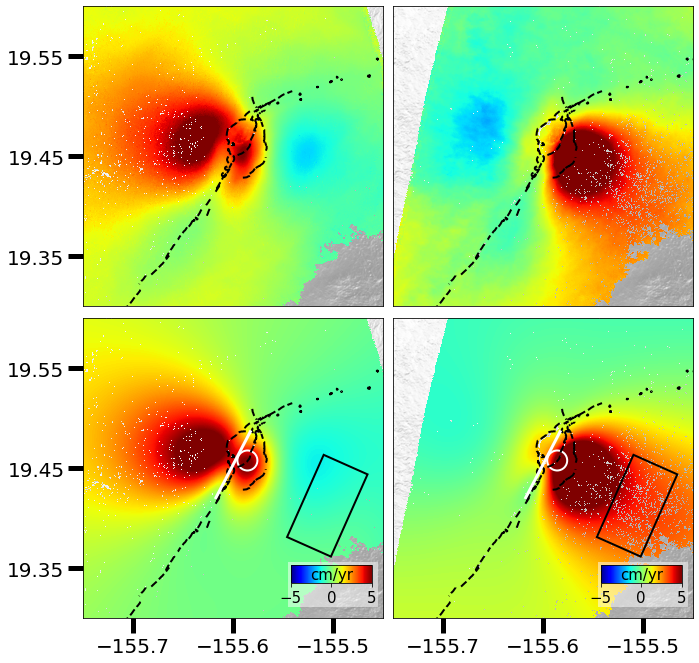

In [28]:
fig,axes= plt.subplots(2,2,figsize=(10,10),sharex=True, sharey=True);
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.95, wspace=0.025,hspace=0.04)
nos=['a','b','c','d','c','d'];
ffsize=20;

for i in range(4):
    #read data
    Asc_data=insar_data[i];
    data_box= Box[i]
    
    #customize axes
    if i<2:
        ax=axes[0,i]
    elif i<4:
        ax=axes[1,i-2]
        
    ax.tick_params(labelsize=ffsize);
    ax.tick_params(axis='x',length=0, width=0);ax.tick_params(axis='y',length=0, width=0);
    if i in [0,2]:
        ax.tick_params(axis='y',length=15, width=5);
    if i in [2,3]:
        ax.tick_params(axis='x',length=15, width=5);
        
    #plot data and model
    map_projection='cyl'
    m = Basemap(llcrnrlon=geo_box[0], llcrnrlat=geo_box[3],\
                urcrnrlon=geo_box[2], urcrnrlat=geo_box[1],\
                projection= map_projection,\
                resolution='c', area_thresh=1., suppress_ticks=False, ax=ax)
    m.imshow(dem_shade, origin='upper', interpolation='spline16')
    m2 = Basemap(llcrnrlon=data_box[0], llcrnrlat=data_box[3],\
                 urcrnrlon=data_box[2], urcrnrlat=data_box[1],\
                 projection= map_projection,\
                 resolution='c', area_thresh=1., suppress_ticks=False, ax=ax)
    img1= m2.imshow(Asc_data*100, origin='upper',cmap='jet',vmin=-5, vmax=5)
    
    #add lines and faults
    ax.plot(lines['Lllh'][:,0],lines['Lllh'][:,1],color='black', linestyle='dashed',linewidth=2)
    
    #add model
    if i in [2,3]:
        ax.plot(dike_lon,dike_lat, 'r-',linewidth=3,color='white')
        c1=Rectangle((fault_lon[3],fault_lat[3]),0.048,0.090,angle=-optimal_model['FAUL Strike'],fill=None,color='black',linewidth=2)
        mogi=plt.Circle((mogi_lon,mogi_lat),0.01,color='white',linewidth=2,fill=False)
        ax.add_artist(c1)
        ax.add_artist(mogi) 
        
    #add colorscale
    if i in [2,3]:
        cbbox = inset_axes(ax, '100%', '50%', loc='lower right',bbox_to_anchor=(0.7, 0.02, 0.3, 0.3),bbox_transform=ax.transAxes)
        [cbbox.spines[k].set_visible(False) for k in cbbox.spines]
        cbbox.set_xticklabels([]);cbbox.set_yticklabels([]);
        cbbox.tick_params(axis='both', left='off', top='off', right='off', bottom='off', 
                          labelleft='off', labeltop='off', labelright='off', labelbottom='off',
                         length=0,width=0);cbbox.set_facecolor([1,1,1,0.5])
        axins1 = inset_axes(ax,width="90%",height="20%",loc='lower right',bbox_to_anchor=(0.68, 0.1, 0.3, 0.3),bbox_transform=ax.transAxes)
        axins1.tick_params(labelsize=15);
        cbar=fig.colorbar(img1, cax=axins1, orientation='horizontal',ticks=[-5,0,5]);
        cbar.set_label('cm/yr', rotation=0,labelpad=-38,size=15)#
        
        
    #set axis limits
    ax.set_ylim((19.3,19.6));ax.set_xlim((-155.75,-155.45))
    ax.set_yticks([19.35, 19.45, 19.55]);ax.set_xticks([-155.7,-155.6,-155.5]);

Get values from Data and Model along a transect. We choose it nearly perpendicualr to the rift at the summit.

In [29]:

def get_transect(insarPlot):
    Lon= insarPlot.ll[:,0]
    Lat= insarPlot.ll[:,1]
    data=insarPlot.data;
    model=insarPlot.model
    points = np.array((Lon.flatten(), Lat.flatten())).T
    f1_nearest = NearestNDInterpolator(points, data.flatten())
    f2_nearest = NearestNDInterpolator(points, model.flatten())
    
    LONS=np.linspace(-155.70,-155.45,200);
    LATS=np.linspace(19.50,19.40,200);
    dist = (((LONS-LONS[0])*105)**2+((LATS-LATS[0])*111)**2)**0.5
    data_val = f1_nearest(LONS,LATS)
    model_val = f2_nearest(LONS,LATS)
    return dist,data_val,model_val

mat =sio.loadmat(inversion_results_file,struct_as_record=False,squeeze_me=True)
profile_dist,data_val,model_val=[],[],[];

for i in range(len(mat['insar'])):
    insar_mat_file = mat['insar'][i].dataPath
    mask = sio.loadmat(insar_mat_file, struct_as_record=False, squeeze_me=True)['Mask']
    length, width = mask.shape
    insarPlot = mat['insarPlot'][i]
    dist,data,model=get_transect(insarPlot)
    profile_dist.append(dist);data_val.append(data);model_val.append(model)
    
    

Plot transect on data and model

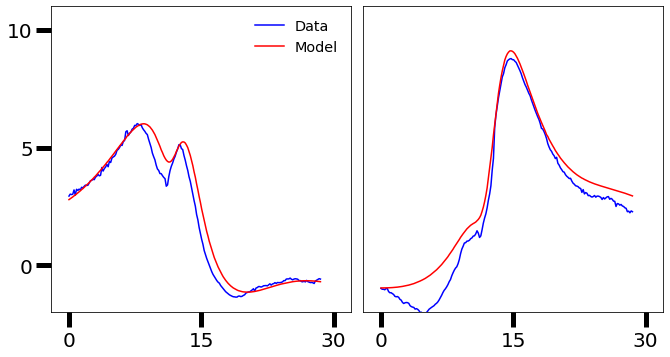

In [30]:
fig,axes= plt.subplots(1,2,figsize=(10,5),sharey=True);
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.95, wspace=0.04,hspace=0.05)

xlim=(-2,32);ylim=(-2,11);
plt.setp(axes, xlim=xlim, ylim=ylim)

for i in range(2):
    axes[i].tick_params(labelsize=20);
    axes[i].tick_params(axis='x',length=15, width=5);
    axes[i].tick_params(axis='y',length=15, width=5);
    axes[i].set_xticks([0,15,30]);
    axes[i].set_ylim((-2,11));
    
ax1=axes[0];ax2=axes[1];
ax2.tick_params(axis='y',length=0, width=0);
ax1.set_yticks([0,5,10])
    
ax1.plot(profile_dist[0],data_val[0]*100,label='Data',color='blue')
ax1.plot(profile_dist[0],model_val[0]*100,label='Model',color='red')
ax2.plot(profile_dist[1],data_val[1]*100,label='Data',color='blue')
ax2.plot(profile_dist[1],model_val[1]*100,label='Model',color='red')
legend = ax1.legend(loc='upper right', shadow=False, fontsize='x-large',frameon=False)

plt.show()

#save figure
#plt.savefig('InSAR_Data_model_profile.pdf',dpi=300,bbox_inches='tight',transparent=True)
